# Tutorial 2: Filtering and Pre-Processing

This notebook shows how to pre-process and filter trajectory dataframes using `nomad`. The `nomad` library currently provides functions for coordinate-system projection, and spatial, temporal, and quantity filtering.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches
from pyproj import Transformer

import nomad.io.base as loader
import nomad.filters as filters
from nomad.filters import to_projection, filter_users, q_filter
from nomad.constants import DEFAULT_SCHEMA
import nomad.city_gen as cg

## Introduction

Researchers often filter geospatial datasets to focus on users or trajectories that meet specific criteria—such as sufficient activity, coverage within a particular timeframe, or presence within defined geographic areas. For example, a study might analyze “users with at least 14 days of activity who visited Central Park during January.” Beyond identifying qualifying users, researchers often need to retrieve these users’ complete trajectories across a wider region to study questions like “Where else do Central Park visitors travel from or to around the world?”

Building such filters typically involves handling polygon operations, coordinate system transformations, and reconciling inconsistent datetime formats from various data sources. Nomad streamlines this process by providing intuitive wrappers around core geospatial libraries like Shapely (via GeoPandas), along with custom functions to evaluate data completeness and quality.

In the sections below, we illustrate how to configure and run both stages of this filtering process:
1.	Sample qualification — identifying users or trajectories that meet specific temporal and spatial criteria.
2.	Trajectory extraction — retrieving the full movement histories of these qualified users over broader geographies.

## Load Data

For the following examples, we load raw test data contained in the `nomad` library. Upon loading the data, we define a schema `traj_cols` that maps a set of standard column names (such as user ID, latitude, longitude, and datetime) to the corresponding columns in the loaded dataframe. This schema ensures compatibility with nomad’s filtering and processing functions.

In [3]:
traj = loader.from_file('gc-sample-data/', format='parquet')

# define schema/column names
traj_cols = {
    "user_id": "uid",
    "latitude": "latitude",
    "longitude": "longitude",
    "datetime": "datetime",
    "timestamp": "timestamp",
    "tz_offset": "tz_offset"}

traj.head(10)

,uid,timestamp,longitude,latitude,datetime,ha,date,tz_offset
0,fervent_knuth,1704107522,-38.317331,36.669819,2024-01-01 07:12:02,20.079080,2024-01-01,-14400
1,fervent_knuth,1704108613,-38.317394,36.669747,2024-01-01 07:30:13,19.085910,2024-01-01,-14400
2,fervent_knuth,1704109838,-38.317479,36.669865,2024-01-01 07:50:38,13.173027,2024-01-01,-14400
3,fervent_knuth,1704110272,-38.317346,36.669794,2024-01-01 07:57:52,9.367617,2024-01-01,-14400
4,fervent_knuth,1704110645,-38.317207,36.670156,2024-01-01 08:04:05,10.999287,2024-01-01,-14400
5,fervent_knuth,1704149735,-38.317458,36.669780,2024-01-01 18:55:35,10.286091,2024-01-01,-14400
6,fervent_knuth,1704154040,-38.317577,36.669823,2024-01-01 20:07:20,8.146017,2024-01-01,-14400
7,fervent_knuth,1704155088,-38.317494,36.669850,2024-01-01 20:24:48,11.449836,2024-01-01,-14400
8,fervent_knuth,1704164362,-38.317490,36.669617,2024-01-01 22:59:22,14.431841,2024-01-01,-14400
9,frosty_neumann,1704118728,-38.317645,36.669408,2024-01-01 10:18:48,41.010484,2024-01-01,-14400


We can visualizes one user's trajectory by plotting their pings overlaid on a map.

For this notebook, suppose we are interested in users who visited the green park during January 2024. The green region denotes the polygon defining the park that we will use as our geographic filter.

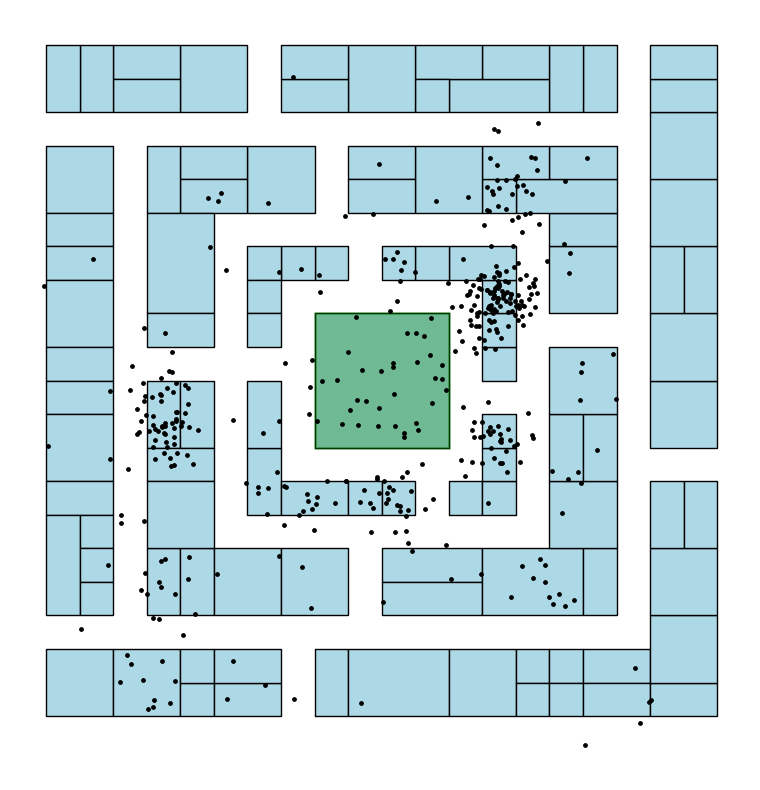

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.box(on=False)

# Load the GeoJSON file of the city map and plot
gdf = gpd.read_file('garden_city.geojson')
gdf.plot(ax=ax, color='lightblue', edgecolor='black', zorder=1)

# Plot the trajectory pings
plot_df = traj[traj['uid'] == "fervent_knuth"].copy()
ax.scatter(x=plot_df['longitude'], 
           y=plot_df['latitude'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Define the polygon coordinates for the park area
polygon_coords = [
    (-38.317674376729549, 36.669298771960719), 
    (-38.317674376729549, 36.669731091674187), 
    (-38.318213365900021, 36.669731091674187), 
    (-38.318213365900021, 36.669298771960719)
]
polygon = Polygon(polygon_coords)
polygon_patch = patches.Polygon(polygon.exterior.coords, 
                                closed=True, 
                                edgecolor='green', 
                                facecolor='green', 
                                alpha=0.35, 
                                linewidth=2, 
                                label="Polygon")
plt.gca().add_patch(polygon_patch)

ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

## Coordinate system projection

The first step after loading the dataset is to ensure the dataset is in the expected coordinate system.

Many geospatial datasets come in spherical coordiantes latitude/longitude (EPSG:4326). However, spatial analyses---like joins of points in polygons, computing buffers, or clustering pings---might benefit from computing euclidean distances. Thus projected planar coordinates (like EPSG:3857) are commonly used. Nomad's `to_projection` method creates new columns `x` and `y` with projected coordinates in any coordinate reference system (CRS) recognized by PyProj. 

In [5]:
# Project to EPSG:3857 (Web Mercator)
projected_x, projected_y = to_projection(traj=traj,
                                         input_crs="EPSG:4326",
                                         output_crs="EPSG:3857",
                                         longitude="longitude",
                                         latitude="latitude")

traj['x'] = projected_x
traj['y'] = projected_y

traj.head(10)

,uid,timestamp,longitude,latitude,datetime,ha,date,tz_offset,x,y
0,fervent_knuth,1704107522,-38.317331,36.669819,2024-01-01 07:12:02,20.079080,2024-01-01,-14400,-4.265466e+06,4.393183e+06
1,fervent_knuth,1704108613,-38.317394,36.669747,2024-01-01 07:30:13,19.085910,2024-01-01,-14400,-4.265473e+06,4.393173e+06
2,fervent_knuth,1704109838,-38.317479,36.669865,2024-01-01 07:50:38,13.173027,2024-01-01,-14400,-4.265482e+06,4.393190e+06
3,fervent_knuth,1704110272,-38.317346,36.669794,2024-01-01 07:57:52,9.367617,2024-01-01,-14400,-4.265467e+06,4.393180e+06
4,fervent_knuth,1704110645,-38.317207,36.670156,2024-01-01 08:04:05,10.999287,2024-01-01,-14400,-4.265452e+06,4.393230e+06
5,fervent_knuth,1704149735,-38.317458,36.669780,2024-01-01 18:55:35,10.286091,2024-01-01,-14400,-4.265480e+06,4.393178e+06
6,fervent_knuth,1704154040,-38.317577,36.669823,2024-01-01 20:07:20,8.146017,2024-01-01,-14400,-4.265493e+06,4.393184e+06
7,fervent_knuth,1704155088,-38.317494,36.669850,2024-01-01 20:24:48,11.449836,2024-01-01,-14400,-4.265484e+06,4.393187e+06
8,fervent_knuth,1704164362,-38.317490,36.669617,2024-01-01 22:59:22,14.431841,2024-01-01,-14400,-4.265484e+06,4.393155e+06
9,frosty_neumann,1704118728,-38.317645,36.669408,2024-01-01 10:18:48,41.010484,2024-01-01,-14400,-4.265501e+06,4.393126e+06


## Apply desired filters

Our library currently allows for three common forms of filtering:
- **Temporal Filtering**: Restrict data to a time window of interest (e.g., January). Use the `start_time` and `end_time` arguments. If 
- **Quantity-Based Filtering**: Keep only users with sufficient activity as measured by a minimum number of pings. Use the `min_active_days` and `min_pings_per_day` arguments.
- **Spatial Filtering**: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia). Use the `polygon` argument.

If the aforementioned arguments are not specified, the default arguments ensure that the respective filtering is not performed. I.e., `polygon` defaults to `None`, and so no spatial filtering is performed.

In [6]:
# Define the polygon for the park area (in projected coordinates)
polygon_coords = [
    (-4265504, 4393111), 
    (-4265504, 4393171), 
    (-4265564, 4393171), 
    (-4265564, 4393111)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)
uq0 = traj['uid'].unique()

filtered_traj = filter_users(traj=traj,
                             # temporal filtering: filter to the specified time range
                             start_time=pd.Timestamp("2024-01-01 00:00:00", tz='America/New_York'),
                             end_time=pd.Timestamp("2024-01-07 23:59:00", tz='America/New_York'),
                             # spatial filtering: filter to the specified polygon
                             polygon=polygon,
                             # quantity-based filtering: filter users based on activity
                             min_active_days=2,
                             min_pings_per_day=10,
                             # define the schema/column names
                             user_id='uid',
                             x='x',
                             y='y')

n1 = len(filtered_traj)
uq1 = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")


Number of pings before filtering: 404448
Number of unique users before filtering: 200
Number of pings after filtering: 32874
Number of unique users after filtering: 36


### Visualize completeness and filter by completeness metric

And here, a discussion on how we want to discard users that have too incomplete a signal to be used. E.g. Q < 80% . 

In [ ]:
#  _generate_Q_matrix(df, traj_cols={'datetime':'event_zoned_datetime', 'user_id':'cuebiq_id'})
# num_days = 42

# q_hourly = Q.mean(axis=0)*100
# q_daily = ((Q>0.0).sum(axis=0)/num_days)*100

# # assume Q is your DataFrame and q_daily is the Series of mean completeness per user
# sorted_cols = q_daily.sort_values(ascending=False).index
# Qs = Q[sorted_cols]
# binary = Qs.gt(0).astype(int)
# cmap = plt.cm.Blues

# fig, axes = plt.subplots(
#     2, 2,
#     figsize=(8, 8),
#     gridspec_kw={'height_ratios': [1, 2.5]},
#     sharey='row'
# )

# # marginal histograms
# axes[0,0].hist(q_daily, bins=46)
# axes[0,0].set_xlabel('% days with data')

# axes[0,1].hist(q_hourly, bins=46)
# axes[0,1].set_xlabel('% hours with data')

# for ax, data in zip([axes[0,1], axes[0,0]], (q_hourly, q_daily)):
#     ax.axvline(np.median(data), linestyle='--', color='red', lw=1)
# # binary heatmap
# sns.heatmap(
#     binary.T,
#     ax=axes[1,0],
#     cmap=cmap,
#     vmin=0, vmax=1,
#     cbar=False,
#     xticklabels=False,
#     yticklabels=False
# )
# axes[1,0].set_ylabel('User')

# # continuous heatmap
# sns.heatmap(
#     Qs.T,
#     ax=axes[1, 1],
#     cmap=cmap,
#     vmin=0, vmax=1,
#     cbar_kws={'label': 'Completeness'},
#     xticklabels=False,
#     yticklabels=False
# )
# axes[1,1].set_ylabel('')

# # set date ticks on bottom row
# dates = pd.to_datetime(Qs.index)
# tick_locs = np.linspace(0, len(dates) - 1, 6, dtype=int)
# tick_lbls = dates.strftime('%m-%d')[tick_locs]
# for ax in [axes[1,0], axes[1,1]]:
#     ax.set_xticks(tick_locs)
#     ax.set_xticklabels(tick_lbls, rotation=45, ha='right')

# #plt.tight_layout()
# plt.show()

The following code constructs a daily $Q$ matrix, which represents the completeness of user activity for each day. $q$ represents the proportion of hours in a day during which a specific user has recorded activity.

In [24]:
# Construct daily Q matrix
Q = filters.generate_Q_matrix(traj, traj_cols)
Q.head(10)

uid,admiring_swirles,admiring_tereshkova,adoring_almeida,adoring_chandrasekhar,adoring_heyrovsky,adoring_khorana,adoring_wright,affectionate_villani,agitated_shirley,amazing_almeida,...,wonderful_austin,xenodochial_lamport,xenodochial_proskuriakova,youthful_jennings,youthful_mayer,youthful_meninsky,youthful_swanson,youthful_thompson,youthful_wilson,zen_hermann
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.166667,0.291667,0.291667,0.708333,0.291667,0.333333,0.458333,0.250000,0.041667,0.333333,...,0.208333,0.291667,0.208333,0.458333,0.416667,0.375000,0.500000,0.541667,0.375000,0.125000
2024-01-02,0.458333,0.333333,0.333333,0.583333,0.291667,0.083333,0.333333,0.333333,0.708333,0.416667,...,0.166667,0.625000,0.291667,0.583333,0.833333,0.083333,0.416667,0.375000,0.208333,0.208333
2024-01-03,0.416667,0.166667,0.208333,0.458333,0.166667,0.708333,0.416667,0.416667,0.666667,0.458333,...,0.291667,0.583333,0.916667,0.625000,0.708333,0.416667,0.500000,0.625000,0.250000,0.708333
2024-01-04,0.708333,0.250000,0.458333,0.208333,0.083333,0.333333,0.500000,0.291667,0.416667,0.458333,...,0.291667,0.875000,0.458333,0.625000,0.708333,0.125000,0.458333,0.250000,0.333333,0.666667
2024-01-05,0.250000,0.291667,0.125000,0.375000,0.250000,0.375000,0.708333,0.333333,0.291667,0.625000,...,0.375000,0.541667,0.750000,0.666667,0.750000,0.375000,0.541667,0.166667,0.166667,0.333333
2024-01-06,0.375000,0.250000,0.166667,0.375000,0.291667,0.333333,0.291667,0.250000,0.416667,0.583333,...,0.250000,0.291667,0.125000,0.791667,0.458333,0.166667,0.625000,0.208333,0.166667,0.375000
2024-01-07,0.375000,0.250000,0.500000,0.000000,0.083333,0.625000,0.208333,0.375000,0.500000,0.333333,...,0.333333,0.208333,0.791667,0.708333,0.708333,0.416667,0.416667,0.416667,0.250000,0.458333
2024-01-08,0.250000,0.625000,0.458333,0.083333,0.083333,0.541667,0.416667,0.375000,0.750000,0.375000,...,0.500000,0.291667,0.208333,0.625000,0.708333,0.583333,0.666667,0.250000,0.166667,0.291667
2024-01-09,0.666667,0.625000,0.083333,0.250000,0.083333,0.583333,0.458333,0.416667,0.458333,0.458333,...,0.250000,0.208333,0.958333,0.541667,0.791667,0.000000,0.333333,0.250000,0.250000,0.250000


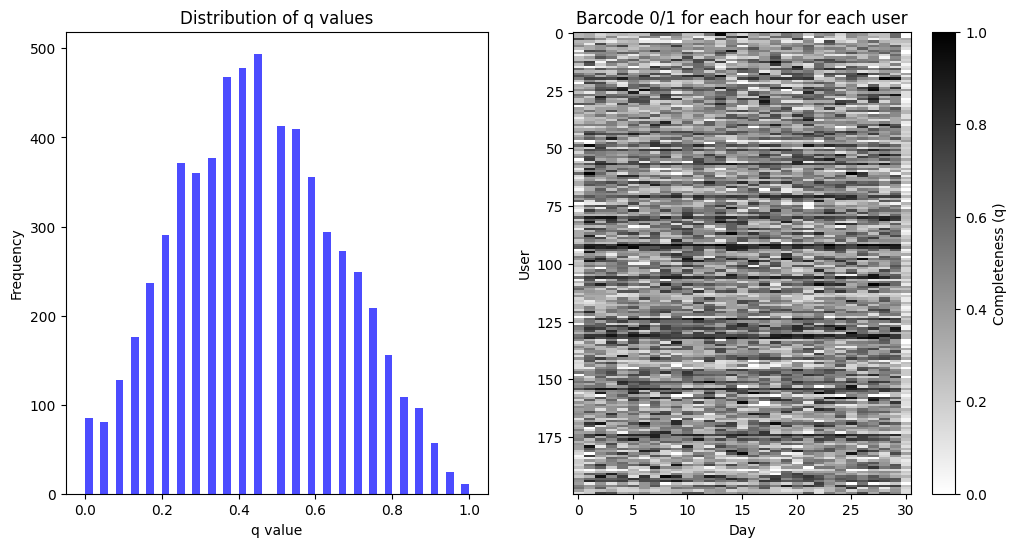

In [31]:
plt.figure(figsize=(12, 6))

# (1) Distribution of q
plt.subplot(1, 2, 1)
plt.title("Distribution of q values")
plt.hist(Q.values.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel("q value")
plt.ylabel("Frequency")

# (2) Barcode 0/1 for each hour for each user
plt.subplot(1, 2, 2)
plt.title("Barcode 0/1 for each hour for each user")
plt.imshow(Q.T, aspect="auto", cmap="gray_r", interpolation="nearest")
plt.xlabel("Day")
plt.ylabel("User")
plt.colorbar(label="Completeness (q)")
plt.show()

We can use $q$ to filter users by completeness, retaining only the users who exhibit a mean completeness of over `qbar` in the sample.

In [ ]:
n0 = len(traj)
uq0 = traj['uid'].unique()

complete_users = q_filter(traj=traj,
                          qbar=0.7,
                          traj_cols=traj_cols)
filtered_traj_q = traj[traj['uid'].isin(complete_users)]

n1 = len(filtered_traj_q)
uq1 = filtered_traj_q['uid'].unique()

print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")

## Applying filters on read

If your dataset is too large. Loading it all in memory to then apply the filters can be intractable. Nomad implements these functionalities to filter in this way on read...